In [1]:
import logging
from importlib.resources import files
from typing import List, Optional

import pandas as pd
import numpy as np
from dotenv import load_dotenv
from tqdm import tqdm

from sklearn.metrics import confusion_matrix


from chatrd.core.utils import ChatMessage
from chatrd.engine.components.query_analyzer import QueryAnalyzer
from chatrd.engine.components.query_analyzer.conversational import (
    ConversationalPrompter,
)
from chatrd.engine.components.query_analyzer.translator.translator import (
    InputModerationTranslator,
)
from chatrd.engine.components.query_analyzer.uc_router import EndpointRouter
from chatrd.engine.components.query_analyzer.utils import TaggedEntity
from chatrd.engine.components.schema import QueryAnalyzerInput
from chatrd.engine.configuration import Constants, get_config_machinery

load_dotenv()
logger = logging.getLogger(__name__)

config_machinery = get_config_machinery()
DEFAULT_MODEL_NAME_FOR_ANALYZER = config_machinery.get_config_value(Constants.GeneralConstants.MODEL_NAME_FOR_ANALYZER)
DEFAULT_TEMPERATURE_FOR_ANALYZER = config_machinery.get_config_value(
    Constants.GeneralConstants.TEMPERATURE_FOR_ANALYZER
)
DEFAULT_MODEL_NAME_FOR_SYNTHESIZER = "claude-3-haiku"
# config_machinery.get_config_value(
#     Constants.GeneralConstants.MODEL_NAME_FOR_SYNTHESIZER
# )
DEFAULT_TEMPERATURE_FOR_SYNTHESIZER = 0.0
# config_machinery.get_config_value(
#     Constants.GeneralConstants.TEMPERATURE_FOR_SYNTHESIZER
# )

DEFAULT_MODEL_NAME_FOR_TOOL_CLASSIFIER = config_machinery.get_config_value(
    Constants.GeneralConstants.MODEL_NAME_FOR_TOOL_CLASSIFIER
)

DEFAULT_TEMPERATURE_FOR_TOOL_CLASSIFIER = config_machinery.get_config_value(
    Constants.GeneralConstants.TEMPERATURE_FOR_TOOL_CLASSIFIER
)

DEFAULT_MODEL_NAME_FOR_DATA_SERVICE = config_machinery.get_config_value(
    Constants.DataService.MODEL_NAME_FOR_DATA_SERVICE
)

DEFAULT_TEMPERATURE_FOR_DATA_SERVICE = config_machinery.get_config_value(
    Constants.DataService.TEMPERATURE_FOR_DATA_SERVICE
)


embeddings_uc_type_path = (
    files("chatrd.engine.data")
    .joinpath(config_machinery.get_config_value(Constants.UCType.UC_EMBEDDING_FILE_NAME))
    .resolve()
)
query_analyzer = QueryAnalyzer(
    embeddings_uc_type_path=str(embeddings_uc_type_path),
    uc_embedding_model=config_machinery.get_config_value(Constants.UCType.UC_EMBEDDING_MODEL),
)

model_name_for_analyzer: Optional[str] = DEFAULT_MODEL_NAME_FOR_ANALYZER
temperature_for_analyzer: Optional[float] = DEFAULT_TEMPERATURE_FOR_ANALYZER
model_name_for_synthesizer: Optional[str] = DEFAULT_MODEL_NAME_FOR_SYNTHESIZER
temperature_for_synthesizer: Optional[float] = DEFAULT_TEMPERATURE_FOR_SYNTHESIZER
model_name_for_tool_classifier: Optional[str] = DEFAULT_MODEL_NAME_FOR_TOOL_CLASSIFIER
temperature_for_tool_classfifer: Optional[float] = DEFAULT_TEMPERATURE_FOR_TOOL_CLASSIFIER
model_name_for_data_service: Optional[str] = DEFAULT_MODEL_NAME_FOR_DATA_SERVICE
temperature_for_data_service: Optional[float] = DEFAULT_TEMPERATURE_FOR_DATA_SERVICE
list_of_tagged_entities: Optional[List[TaggedEntity]] = []
chat_history: Optional[List[ChatMessage]] = []
streaming: Optional[bool] = False

# Micro/macro subrouter needed imports
from chatrd.engine.components.query_processor.query_retriever.uc_retrievers.prompt_templates import (
    GENERAL_EXAMPLES,
    GENERAL_PROMPTS,
)
from chatrd.core.llm.parsers import OutputParserException, PydanticOutputParser
from chatrd.core.llm.prompt.template import SimplePromptTemplate
from chatrd.engine.components.query_processor.query_retriever.uc_retrievers.utils import (
    GeneralRetrieverModel,)
from chatrd.core.llm import LCLLMFactory

# Entity extractor needed imports
from chatrd.engine.components.query_analyzer.entity_extractor import EntityExtractor



In [2]:
import pandas as pd

file_path = "/home/sagemaker-user/creditcompanion/scripts/general_subrouting/golden_dataset.csv"

golden_df = pd.read_csv(file_path, encoding="latin-1")

In [3]:
general_uc_df = golden_df[golden_df["Routing"] == "general"]
general_uc_df

Query  Routing   
0     in reagrds to Holcim Solutions and Products US...  general  \
1     anything on EdgeCore Digital Infrastructure's ...  general   
2     provide a one paragraph highlighting the busin...  general   
3     can you give me some research paper related to...  general   
4                give me industry report on copper foil  general   
...                                                 ...      ...   
1407  What are the Digitalization, AI, Climate Chang...  general   
1409  find this notion of societe publique locale (S...  general   
4455  Which Asian auto-makers are impacted by trump ...  general   
4456  Provide examples of companies that have a fair...  general   
4457  Provide examples of mining companies that have...  general   

                                            Sub-Routing  
0                 General - Micro (Tagged to an entity)  
1                 General - Micro (Tagged to an entity)  
2                 General - Micro (Tagged to an entity)  
3       general - macro (not tagged to specific entity)  
4       general - macro (not tagged to specific entity)  
...                                                 ...  
1407    general - macro (not tagged to specific entity)  
1409  general - micro and macro (tagged to specific ...  
4455  general - micro and macro (not tagged to speci...  
4456  general - micro and macro (not tagged to speci...  
4457  general - micro and macro (not tagged to speci...  

[604 rows x 3 columns]

In [4]:
general_uc_df["Sub-Routing"].unique()

array(['General - Micro (Tagged to an entity)',
       'general - macro (not tagged to specific entity)',
       'General - Micro and Macro (Tagged to an entity)',
       'general - micro (tagged to specific entity)',
       'general - micro (tagged to entity)',
       'General - Micro (Not Tagged to an entity)',
       'general - micro and macro (not tagged to specific entity)',
       'General - micro and macro (tagged to an entity)',
       'general - micro and macro (tagged to specific entity)',
       'Client Support Sub-Routing', nan, 'Blocked Topics', ' '],
      dtype=object)

In [5]:
# Function to extract sub-routing and entity tagging
def extract_subrouting(row):
    if pd.isna(row):
        return pd.Series(["invalid", "invalid"])
    
    # Default values
    subrouting_result = np.nan
    entity_result = np.nan
    
    # Check for micro, macro, or both
    if "micro" in row.lower() and "macro" in row.lower():
        subrouting_result = "micro_macro"
    elif "micro" in row.lower():
        subrouting_result = "micro"
    elif "macro" in row.lower():
        subrouting_result = "macro"
    else:
        subrouting_result = "invalid"
    
    # Check if tagged to an entity (switched order)
    if "not tagged" in row.lower():
        entity_result = "not_tagged"
    elif "tagged" in row.lower():
        entity_result = "tagged"
    else:
        entity_result = "invalid"
    
    return pd.Series([subrouting_result, entity_result])

# Apply the function to create new columns
general_uc_df[["golden_subrouting_result", "golded_entity_result"]] = general_uc_df["Sub-Routing"].apply(extract_subrouting)
general_uc_df["golden_result"] = general_uc_df["golden_subrouting_result"].astype(str)

/tmp/ipykernel_40415/530575355.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general_uc_df[["golden_subrouting_result", "golded_entity_result"]] = general_uc_df["Sub-Routing"].apply(extract_subrouting)
/tmp/ipykernel_40415/530575355.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general_uc_df[["golden_subrouting_result", "golded_entity_result"]] = general_uc_df["Sub-Routing"].apply(extract_subrouting)
/tmp/ipykernel_40415/530575355.py:32: SettingWithCopyWarning: 
A value is trying to be set on 

In [6]:
# Dropping invalid entries
general_uc_df = general_uc_df[general_uc_df["golden_result"] != "invalid"]

In [7]:
# Uncomment for testing with a smaller dataset
# general_uc_df = general_uc_df[:5]

In [8]:
uc_router = EndpointRouter(model_name="endpoint_embedder")

conversational_prompter = ConversationalPrompter(
    model_name=model_name_for_analyzer, temperature=temperature_for_analyzer
)

predicted_uc_types = []

issue_with_conversational_prompter_results = []
rephrases = []
all_sub_routes = []
is_micro=[]
is_macro=[]
entities=[]

parser = PydanticOutputParser(pydantic_object=GeneralRetrieverModel)
prompt_template = SimplePromptTemplate(GENERAL_PROMPTS)
llm = LCLLMFactory().get_llm(deployment_name_or_model_id=model_name_for_analyzer,temperature=temperature_for_analyzer)


entity_extractor = EntityExtractor(model_name=model_name_for_analyzer, temperature=temperature_for_analyzer)

for message in tqdm(general_uc_df["Query"].tolist()):
    subroutes = []
    decision, conversational_prompter_output = conversational_prompter.run(message, chat_history)
    issue_with_conversational_prompter = (False, conversational_prompter_output)
    if decision.flag == "rephrasing":
        message = conversational_prompter_output.rephrased_initial_question
        rephrases.append(message)
        # get routes for subqueries
        # for q in conversational_prompter_output.subqueries:
            # subroutes.append(uc_router.run(q)[0])
    else:
        issue_with_conversational_prompter = (True, conversational_prompter_output)
        rephrases.append([])

    # all_sub_routes.append(subroutes)

    # uc_type = uc_router.run(message)[0]
    # predicted_uc_types.append(uc_type)
    issue_with_conversational_prompter_results.append(issue_with_conversational_prompter)
    prompt = prompt_template.format(
        **{
                    "question": message,
                    "examples": GENERAL_EXAMPLES,
                }
            )
    subrouter_response = llm.invoke(prompt)
    parsed_response = parser.parse(subrouter_response.content)
    is_micro.append(parsed_response.is_micro)
    is_macro.append(parsed_response.is_macro)
    # entity_extractor_result = entity_extractor.run(query=message, list_of_tagged_entities=[])
    # entities.append(entity_extractor_result)
    

  0%|          | 0/589 [00:00<?, ?it/s]

100%|██████████| 589/589 [21:45<00:00,  2.22s/it]


In [9]:
# Add values to df
# general_uc_df["predicted_uc_type"] = predicted_uc_types
general_uc_df["rephrases"] = rephrases
# general_uc_df["all_sub_routes"] = all_sub_routes
general_uc_df["issue_with_conversational_prompter"] = issue_with_conversational_prompter_results
general_uc_df["is_micro"] = is_micro
general_uc_df["is_macro"] = is_macro
# general_uc_df["entities"] = entities

/tmp/ipykernel_40415/479689419.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general_uc_df["rephrases"] = rephrases
/tmp/ipykernel_40415/479689419.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general_uc_df["issue_with_conversational_prompter"] = issue_with_conversational_prompter_results
/tmp/ipykernel_40415/479689419.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [10]:
# Process entity tagging results

def process_entities(entities):
    if entities[0].companies + entities[0].securities + entities[0].revenue_sources != []:
        return "tagged"
    else:   
        return "not_tagged"

# general_uc_df["processed_entities"] = general_uc_df["entities"].apply(process_entities)

In [11]:
# Create variable

def predict_subrouting(row):
    parts = []
    if row["is_micro"]:
        parts.append("micro")
    if row["is_macro"]:
        parts.append("macro")
    # parts.append(row["processed_entities"])
    return "_".join(parts)

general_uc_df["predicted_subrouting"] = general_uc_df.apply(predict_subrouting, axis=1)

/tmp/ipykernel_40415/654504527.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general_uc_df["predicted_subrouting"] = general_uc_df.apply(predict_subrouting, axis=1)


In [12]:
# Filter out conversational issues

general_uc_df["has_conversational_issue"] = general_uc_df["issue_with_conversational_prompter"].apply(lambda x: x[0])
general_uc_df = general_uc_df[general_uc_df["has_conversational_issue"] == False]

/tmp/ipykernel_40415/446902274.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general_uc_df["has_conversational_issue"] = general_uc_df["issue_with_conversational_prompter"].apply(lambda x: x[0])


In [13]:
def calculate_multiclass_tpr_fpr(y_true, y_pred):
    classes = np.unique(y_true)
    
    tpr = {}
    fpr = {}
    
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    for i, cls in enumerate(classes):
        TP = cm[i, i]
        FN = cm[i].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FP + FN)

        tpr[cls] = TP / (TP + FN) if (TP + FN) > 0 else 0
        fpr[cls] = FP / (FP + TN) if (FP + TN) > 0 else 0

    for cls in classes:
        print(f"Subroute {cls}: TPR = {tpr[cls]:.2f}, FPR = {fpr[cls]:.2f}")

    return tpr, fpr


tpr, fpr = calculate_multiclass_tpr_fpr(general_uc_df["golden_result"], general_uc_df["predicted_subrouting"])

Subroute macro: TPR = 0.91, FPR = 0.21
Subroute micro: TPR = 0.84, FPR = 0.12
Subroute micro_macro: TPR = 0.35, FPR = 0.09


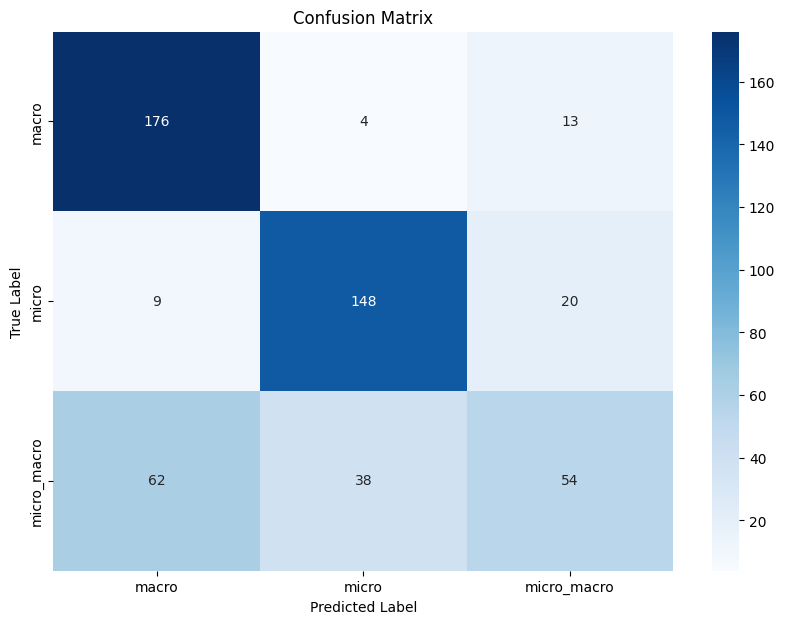

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    all_classes = np.unique(np.concatenate((y_true, y_pred)))
    
    cm = confusion_matrix(y_true, y_pred, labels=all_classes)
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=all_classes, yticklabels=all_classes)

    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

plot_confusion_matrix(general_uc_df["golden_result"], general_uc_df["predicted_subrouting"])

# Saving results

In [15]:
import io
from sklearn.metrics import ConfusionMatrixDisplay

In [16]:
def save_cm(y_true, y_pred):
    all_classes = np.unique(np.concatenate((y_true, y_pred)))
    
    cm = confusion_matrix(y_true, y_pred, labels=all_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_classes)

    fig, ax = plt.subplots(figsize=(5,5), dpi=150)
    disp.plot(ax=ax, values_format='d', colorbar=False)
    ax.set_title('Confusion Matrix')

    img_buf = io.BytesIO()
    fig.tight_layout()
    fig.savefig(img_buf, format='png', bbox_inches='tight')
    plt.close(fig)
    img_buf.seek(0)

    return img_buf

img_buf = save_cm(general_uc_df["golden_result"], general_uc_df["predicted_subrouting"])

In [17]:
metrics_df = pd.concat([pd.Series(tpr, name="TPR"), pd.Series(fpr, name="FPR")], axis=1)
metrics_df.index.name = "class"
print(metrics_df)

                  TPR       FPR
class                          
macro        0.911917  0.214502
micro        0.836158  0.121037
micro_macro  0.350649  0.089189


In [18]:
general_uc_df['is_correct'] = general_uc_df['predicted_subrouting'].eq(general_uc_df["golden_subrouting_result"])

In [19]:
columns_to_save = ["Query","rephrases","Sub-Routing","golden_subrouting_result","predicted_subrouting",'is_correct']
output_df = general_uc_df[columns_to_save]
wrong_df = general_uc_df[(general_uc_df["predicted_subrouting"]!=general_uc_df["golden_subrouting_result"])][columns_to_save]

prompt_text = f"EXAMPLES \n\n {GENERAL_EXAMPLES} \n\n PROMPT \n\n {GENERAL_PROMPTS}"
df_prompt = pd.DataFrame({"Prompt": [prompt_text]})

out_path = "/home/sagemaker-user/creditcompanion/scripts/general_subrouting/report.xlsx"
with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
    # Saving all output dataframe
    output_df.to_excel(writer, sheet_name="All_Data", index=True)

    # Saving wrong subrouting dataframe
    wrong_df.to_excel(writer, sheet_name="Wrong_Predictions", index=True)

    # Saving metrics
    metrics_df.to_excel(writer, sheet_name="Metrics", index=True)
    
    # Saving confusion matrix
    workbook = writer.book
    ws = workbook.add_worksheet("ConfusionMatrix")
    ws.insert_image("B2", "cm.png", {"image_data": img_buf})

    # Saving utilized prompt
    df_prompt.to_excel(writer, sheet_name="Prompt", index=False)
    worksheet = writer.sheets["Prompt"]
    wrap_format = workbook.add_format({
        "text_wrap": True,
        "valign": "top"
    })
    worksheet.set_column("A:A", 80, wrap_format)
    text_lines = 250
    worksheet.set_row(1, 15*text_lines)